In [1]:
## PACKAGES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import sys
sys.path.insert(1,'C:\Zmyfiles\codes\research\KPCA-DA\KPCA_DA\examples\Scripts')
from pyDeepInsightv3 import ImageTransformer

c:\Users\sheli\anaconda3\envs\SheliaWorkspace\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Data1
#expr_file1 = r"..\Data\TCGAvsDesmd\modified_TCGA_BRCA_log2.csv"
expr_file1 = r"..\Data\TvsN\TCGA_BRCA_NvT.csv"
#expr_file1 = r"..\Data\cptacvssmc\cptac_labels.csv"
#expr_file = r"..\data\Survival_TCGA_VS_Desmd\smc_labels.csv"
# expr1 = pd.read_csv(expr_file, encoding='utf-8', engine='python')
# expr=expr1.transpose()
# expr.columns=expr.iloc[0]
# X_all = expr.iloc[1:,1:-1].values
# X_all=X_all.astype(float)
# days= expr.iloc[1:,-1].values
# genes = expr.iloc[:,:-1].columns.to_numpy()
expr1 = pd.read_csv(expr_file1, encoding='utf-8', engine='python')
expr1=expr1.transpose()
expr1.columns=expr1.iloc[0]
X1 = expr1.iloc[1:,0:-1].values
X1=X1.astype(float)
Y1 = expr1.iloc[1:,-1].values
genes1 = expr1.iloc[:,:-1].columns.to_numpy()

##LOAD DATA2
#expr_file2 = r"..\Data\TCGAvsDesmd\filtered_desmd_average.csv"
expr_file2 = r"..\Data\TvsN\GSE45498_NvT.csv"
#expr_file2 = r"..\Data\cptacvssmc\smc_labels.csv"
#expr_file = r"..\data\Survival_TCGA_VS_Desmd\smc_labels.csv"
# expr1 = pd.read_csv(expr_file, encoding='utf-8', engine='python')
# expr=expr1.transpose()
# expr.columns=expr.iloc[0]
# X_all = expr.iloc[1:,1:-1].values
# X_all=X_all.astype(float)
# days= expr.iloc[1:,-1].values
# genes = expr.iloc[:,:-1].columns.to_numpy()
expr2 = pd.read_csv(expr_file2, encoding='utf-8', engine='python')
expr2=expr2.transpose()
expr2.columns=expr2.iloc[0]
X2 = expr2.iloc[1:,0:-1].values
X2=X2.astype(float)
Y2 = expr2.iloc[1:,-1].values
genes2 = expr2.iloc[:,:-1].columns.to_numpy()

In [3]:
# Split X2 dataset into 70-30
X2_adapt, X2_test, Y2_adapt, Y2_test = train_test_split(
    X2, Y2, test_size=0.3, random_state=42, stratify=Y2)

## DeepInsight Image Transformation
Convert data to image format using DeepInsight

In [4]:
from sklearn.decomposition import PCA, KernelPCA

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(
#       X, Y, test_size=0.3, random_state=5, stratify=Y)

X_train, X_test, y_train, y_test = X1,X2_test,Y1,Y2_test

var_filter1 = X_train.var(0) >= np.percentile(X_train.var(0), 10., method='nearest')
var_filter2 = X_test.var(0) >= np.percentile(X_test.var(0), 10., method='nearest')

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter1])
X_test_norm = mms.fit_transform(X_test[:, var_filter2])

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

### UMAP Visualization of Source vs Target Expression Data (Before Image Transformation)
Visualize distribution differences between source and target expression datasets using UMAP before converting to images

Applying ICA to source and target expression datasets...
Fitting UMAP on source expression data only...


c:\Users\sheli\anaconda3\envs\SheliaWorkspace\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Test data ranges - X: 7.890337, Y: 3.639942
Source data ranges - X: 7.517097, Y: 7.251137
Applied jitter to test data: x_jitter=0.3759, y_jitter=0.3626


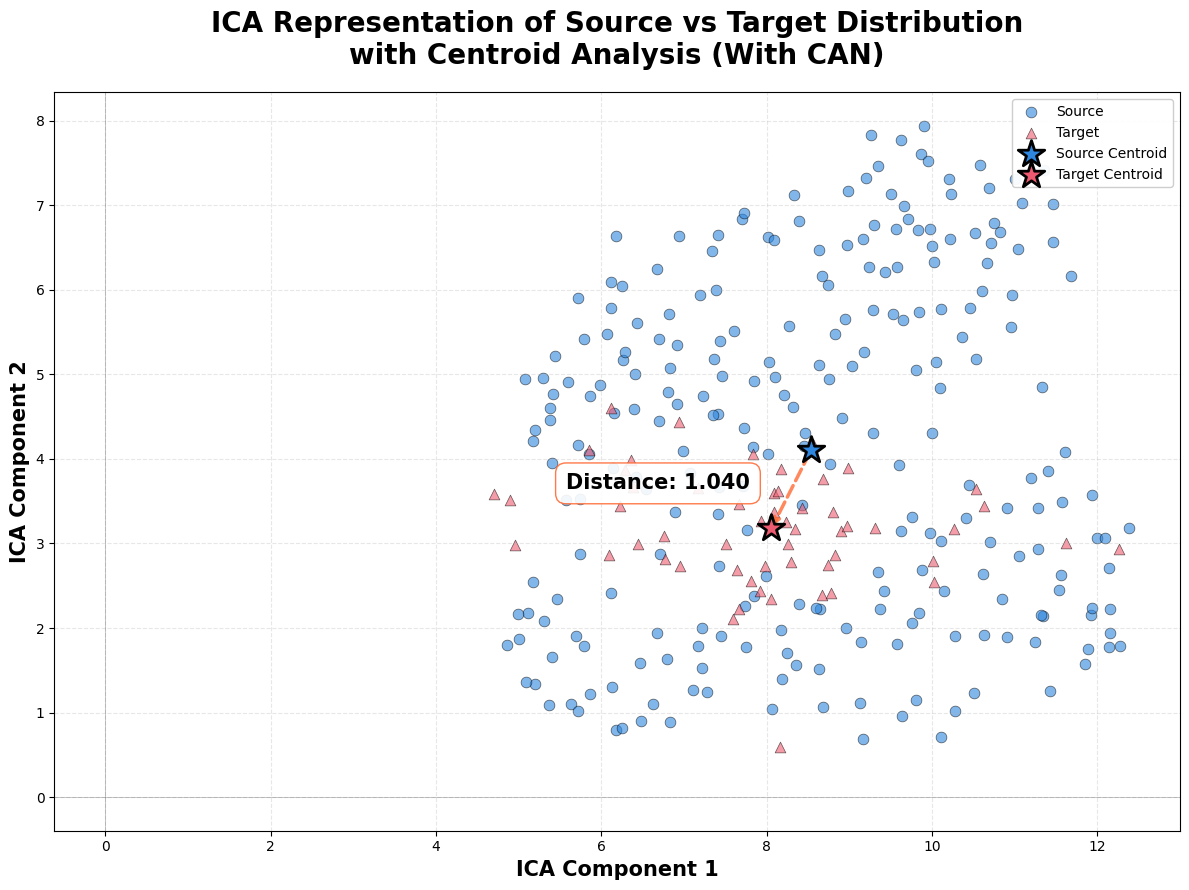


     ICA DISTRIBUTION ANALYSIS (Expression Data - Before Images)      

Source Dataset (TCGA):
  Samples: 250
  Centroid: (8.5372, 4.1017)
  Std Dev:  (2.0372, 1.9982)

Target Dataset (GSE45498):
  Samples: 55
  Centroid: (8.0589, 3.1777)
  Std Dev:  (1.5060, 0.5521)

Centroid Difference:
  Euclidean Distance: 1.0404
  Component 1 Shift:  0.4782
  Component 2 Shift:  0.9240



In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Apply UMAP to source and target expression data (before image conversion)
print("Applying ICA to source and target expression datasets...")
reducer_umap_expr = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.5)

# Fit UMAP only on source expression data
print("Fitting UMAP on source expression data only...")
reducer_umap_expr.fit(X_train_norm)

# Transform source and target separately using the source-fitted UMAP
X_train_umap_expr = reducer_umap_expr.transform(X_train_norm)
X_test_umap_expr = reducer_umap_expr.transform(X_test_norm)

# Add jitter to test data for better visualization
x_range_source_expr = X_train_umap_expr[:, 0].max() - X_train_umap_expr[:, 0].min()
y_range_source_expr = X_train_umap_expr[:, 1].max() - X_train_umap_expr[:, 1].min()
x_range_test_expr = X_test_umap_expr[:, 0].max() - X_test_umap_expr[:, 0].min()
y_range_test_expr = X_test_umap_expr[:, 1].max() - X_test_umap_expr[:, 1].min()

print(f"Test data ranges - X: {x_range_test_expr:.6f}, Y: {y_range_test_expr:.6f}")
print(f"Source data ranges - X: {x_range_source_expr:.6f}, Y: {y_range_source_expr:.6f}")

# Use 5% of source data range for jitter
jitter_scale_expr = 0.05
x_jitter_expr = max(x_range_source_expr * jitter_scale_expr, 0.1)
y_jitter_expr = max(y_range_source_expr * jitter_scale_expr, 0.1)

# Add random jitter to test data
np.random.seed(42)
X_test_umap_expr_jittered = X_test_umap_expr.copy()
X_test_umap_expr_jittered[:, 0] += np.random.normal(0, x_jitter_expr, len(X_test_umap_expr))
X_test_umap_expr_jittered[:, 1] += np.random.normal(0, y_jitter_expr, len(X_test_umap_expr))

print(f"Applied jitter to test data: x_jitter={x_jitter_expr:.4f}, y_jitter={y_jitter_expr:.4f}")

# Calculate centroids (use original positions for accurate centroids)
centroid_source_expr = X_train_umap_expr.mean(axis=0)
centroid_target_expr = X_test_umap_expr.mean(axis=0)

# Calculate Euclidean distance between centroids
centroid_distance_expr = np.linalg.norm(centroid_source_expr - centroid_target_expr)

# Define distinct colors for source and target
color_source = '#2E86DE'  # Bright blue for source
color_target = '#EE5A6F'  # Bright red/pink for target

# Create visualization
fig, ax = plt.subplots(figsize=(12, 9))

# Plot source data (TCGA)
ax.scatter(X_train_umap_expr[:, 0], X_train_umap_expr[:, 1], 
           c=color_source, alpha=0.6, s=60, marker='o',
           label=f'Source', 
           edgecolors='k', linewidth=0.5)

# Plot target data (GSE45498) with jitter
ax.scatter(X_test_umap_expr_jittered[:, 0], X_test_umap_expr_jittered[:, 1], 
           c=color_target, alpha=0.6, s=60, marker='^',
           label=f'Target', 
           edgecolors='k', linewidth=0.5)

# Plot centroids
ax.scatter(centroid_source_expr[0], centroid_source_expr[1], 
           c=color_source, s=400, marker='*',
           label='Source Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

ax.scatter(centroid_target_expr[0], centroid_target_expr[1], 
           c=color_target, s=400, marker='*',
           label='Target Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

# Draw arrow showing centroid difference
ax.annotate('', xy=centroid_target_expr, xytext=centroid_source_expr,
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#FF6B35', 
                          linestyle='--', alpha=0.8))

# Add text showing distance
mid_point_expr = (centroid_source_expr + centroid_target_expr) / 2
# Shift text to the left by adjusting x-coordinate
ax.text(mid_point_expr[0] - 0.5, mid_point_expr[1], 
        f'Distance: {centroid_distance_expr:.3f}',
        fontsize=15, fontweight='bold', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                 edgecolor='#FF6B35', alpha=0.9),
        ha='right')

# mid_point = (centroid_source_expr + centroid_target_expr) / 2
# # Calculate perpendicular offset to move label away from line
# line_vector = centroid_source_expr - centroid_target_expr
# perpendicular = np.array([-line_vector[1], line_vector[0]])
# perpendicular = perpendicular / np.linalg.norm(perpendicular) if np.linalg.norm(perpendicular) > 0 else perpendicular
# offset_distance = 0.1  # Distance to move label away from line
# label_position = mid_point + perpendicular * offset_distance


# Add distribution statistics
# stats_text_expr = f'Source: μ=({centroid_source_expr[0]:.2f}, {centroid_source_expr[1]:.2f}), σ=({X_train_umap_expr[:, 0].std():.2f}, {X_train_umap_expr[:, 1].std():.2f})\n'
# stats_text_expr += f'Target: μ=({centroid_target_expr[0]:.2f}, {centroid_target_expr[1]:.2f}), σ=({X_test_umap_expr[:, 0].std():.2f}, {X_test_umap_expr[:, 1].std():.2f})'
# ax.text(0.02, 0.98, stats_text_expr,
#         transform=ax.transAxes, fontsize=9,
#         verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_title('ICA Representation of Source vs Target Distribution\nwith Centroid Analysis (With CAN)', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('ICA Component 1', fontsize=15, fontweight='bold')
ax.set_ylabel('ICA Component 2', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*70}")
print(f"{'ICA DISTRIBUTION ANALYSIS (Expression Data - Before Images)':^70}")
print(f"{'='*70}")
print(f"\nSource Dataset (TCGA):")
print(f"  Samples: {len(X_train_umap_expr)}")
print(f"  Centroid: ({centroid_source_expr[0]:.4f}, {centroid_source_expr[1]:.4f})")
print(f"  Std Dev:  ({X_train_umap_expr[:, 0].std():.4f}, {X_train_umap_expr[:, 1].std():.4f})")

print(f"\nTarget Dataset (GSE45498):")
print(f"  Samples: {len(X_test_umap_expr)}")
print(f"  Centroid: ({centroid_target_expr[0]:.4f}, {centroid_target_expr[1]:.4f})")
print(f"  Std Dev:  ({X_test_umap_expr[:, 0].std():.4f}, {X_test_umap_expr[:, 1].std():.4f})")

print(f"\nCentroid Difference:")
print(f"  Euclidean Distance: {centroid_distance_expr:.4f}")
print(f"  Component 1 Shift:  {abs(centroid_target_expr[0] - centroid_source_expr[0]):.4f}")
print(f"  Component 2 Shift:  {abs(centroid_target_expr[1] - centroid_source_expr[1]):.4f}")
print(f"{'='*70}\n")

In [82]:
# Calculate Wasserstein distance
from scipy.stats import wasserstein_distance

# Calculate Wasserstein distance for each component
wasserstein_comp1 = wasserstein_distance(X_train_umap_expr[:, 0], X_test_umap_expr[:, 0])
wasserstein_comp2 = wasserstein_distance(X_train_umap_expr[:, 1], X_test_umap_expr[:, 1])
# Average Wasserstein distance across components
wasserstein_avg = (wasserstein_comp1 + wasserstein_comp2) / 2

print(f"\n{'='*70}")
print(f"{'Wasserstein Distance':^70}")
print(f"{'='*70}")
print(f"  Component 1: {wasserstein_comp1:.4f}")
print(f"  Component 2: {wasserstein_comp2:.4f}")
print(f"  Average: {wasserstein_avg:.4f}")
print(f"{'='*70}\n")


                         Wasserstein Distance                         
  Component 1: 0.7048
  Component 2: 1.5229
  Average: 1.1139



In [6]:
reducer=KernelPCA(n_components=2, kernel='rbf',gamma=.2)

pixel_size = (227,227)

it1 = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

it2 = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

print("source shape:", X_train_norm.shape)
print("source shape:", X_test_norm.shape)

it1.fit(X_train_norm, y=y_train, plot=False)
it2.fit(X_test_norm, y=y_test, plot=False)

print("source shape:", X_train_norm.shape)
print("source shape:", X_test_norm.shape)

X_train_img = it1.transform(X_train_norm)
X_test_img = it2.transform(X_test_norm)

source shape: (250, 20240)
source shape: (55, 212)
source shape: (250, 20240)
source shape: (55, 212)


### ICA Visualization of Source vs Target Distribution
Visualize distribution differences between source and target datasets using Independent Component Analysis (ICA)

Flattening images for ICA analysis...
Flattened source images shape: (250, 154587)
Flattened target images shape: (55, 154587)
Applying ICA to source and target image datasets...
Fitting ICA on source data only...
Test data ranges - X: 0.020313, Y: 0.040781
Source data ranges - X: 4.054839, Y: 5.111283


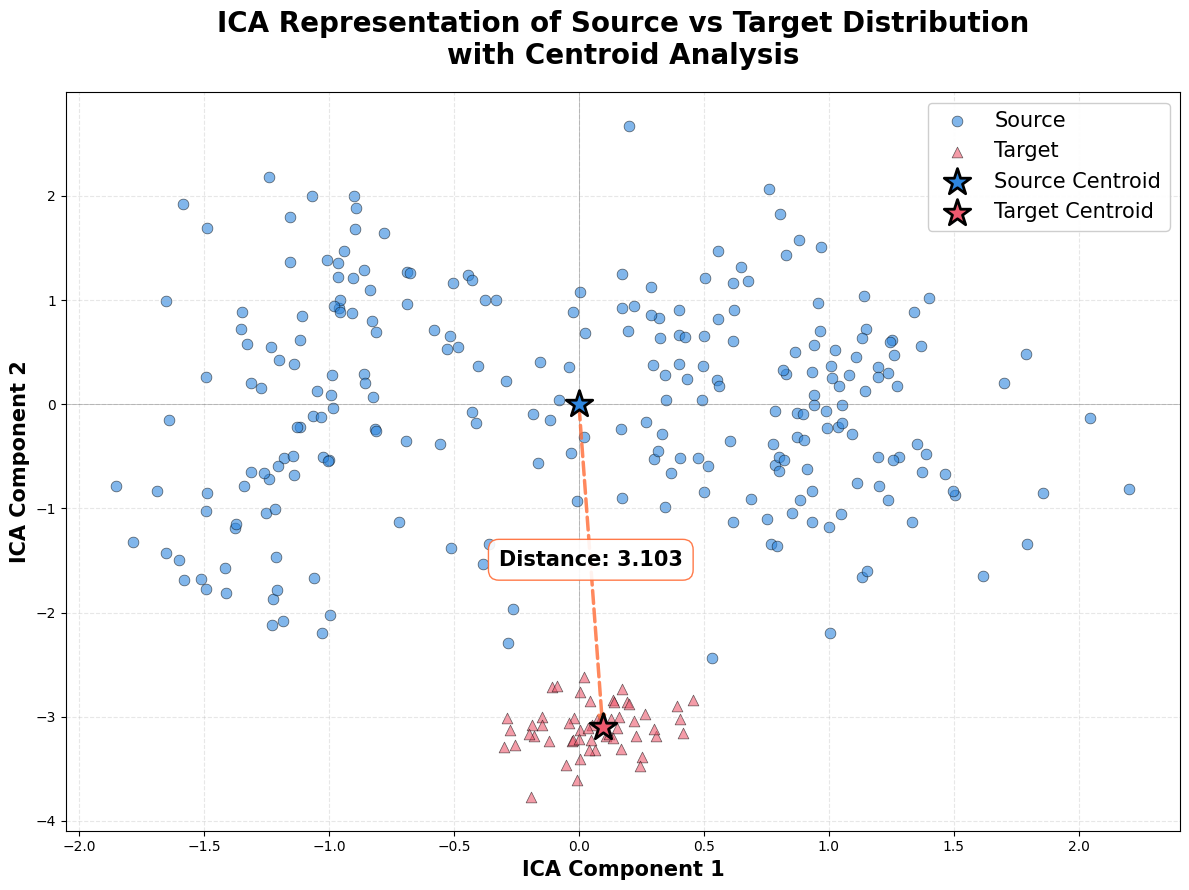


               ICA DISTRIBUTION ANALYSIS (Image-based)                

Source Dataset (TCGA):
  Samples: 250
  Centroid: (0.0000, 0.0000)
  Std Dev:  (1.0000, 1.0000)

Target Dataset (GSE45498):
  Samples: 55
  Centroid: (0.0951, -3.1017)
  Std Dev:  (0.0040, 0.0066)

Centroid Difference:
  Euclidean Distance: 3.1031
  Component 1 Shift:  0.0951
  Component 2 Shift:  3.1017



In [8]:
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import numpy as np

# Flatten images for ICA (from 227x227x3 to 1D vectors)
print("Flattening images for ICA analysis...")
X_train_img_flat = X_train_img.reshape(X_train_img.shape[0], -1)
X_test_img_flat = X_test_img.reshape(X_test_img.shape[0], -1)

print(f"Flattened source images shape: {X_train_img_flat.shape}")
print(f"Flattened target images shape: {X_test_img_flat.shape}")

# Apply ICA to source and target image datasets
print("Applying ICA to source and target image datasets...")
ica = FastICA(n_components=2, random_state=42, max_iter=500)

# Fit ICA only on source data, then transform both
print("Fitting ICA on source data only...")
ica.fit(X_train_img_flat)

# Transform source and target separately using the source-fitted ICA
X_train_ica = ica.transform(X_train_img_flat)
X_test_ica = ica.transform(X_test_img_flat)

# Add jitter to test data for better visualization
# Use source data range as reference since test data may have zero variance
x_range_source = X_train_ica[:, 0].max() - X_train_ica[:, 0].min()
y_range_source = X_train_ica[:, 1].max() - X_train_ica[:, 1].min()
x_range_test = X_test_ica[:, 0].max() - X_test_ica[:, 0].min()
y_range_test = X_test_ica[:, 1].max() - X_test_ica[:, 1].min()

print(f"Test data ranges - X: {x_range_test:.6f}, Y: {y_range_test:.6f}")
print(f"Source data ranges - X: {x_range_source:.6f}, Y: {y_range_source:.6f}")

# Use 5% of source data range for jitter (more aggressive)
jitter_scale = 0.05
x_jitter = max(x_range_source * jitter_scale, 0.1)  # At least 0.1 jitter
y_jitter = max(y_range_source * jitter_scale, 0.1)

# Add random jitter to test data
np.random.seed(42)  # For reproducibility
X_test_ica_jittered = X_test_ica.copy()
X_test_ica_jittered[:, 0] += np.random.normal(0, x_jitter, len(X_test_ica))
X_test_ica_jittered[:, 1] += np.random.normal(0, y_jitter, len(X_test_ica))

#print(f"Applied jitter to test data: x_jitter={x_jitter:.4f}, y_jitter={y_jitter:.4f}")

# Calculate centroids (use original positions for accurate centroids)
centroid_source = X_train_ica.mean(axis=0)
centroid_target = X_test_ica.mean(axis=0)

# Calculate Euclidean distance between centroids
centroid_distance = np.linalg.norm(centroid_source - centroid_target)

# Define distinct colors for source and target
color_source = '#2E86DE'  # Bright blue for source
color_target = '#EE5A6F'  # Bright red/pink for target

# Create visualization
fig, ax = plt.subplots(figsize=(12, 9))

# Plot source data (TCGA)
ax.scatter(X_train_ica[:, 0], X_train_ica[:, 1], 
           c=color_source, alpha=0.6, s=60, marker='o',
           label=f'Source', 
           edgecolors='k', linewidth=0.5)

# Plot target data (GSE45498) with jitter
ax.scatter(X_test_ica_jittered[:, 0], X_test_ica_jittered[:, 1], 
           c=color_target, alpha=0.6, s=60, marker='^',
           label=f'Target', 
           edgecolors='k', linewidth=0.5)

# Plot centroids
ax.scatter(centroid_source[0], centroid_source[1], 
           c=color_source, s=400, marker='*',
           label='Source Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

ax.scatter(centroid_target[0], centroid_target[1], 
           c=color_target, s=400, marker='*',
           label='Target Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

# Draw arrow showing centroid difference
ax.annotate('', xy=centroid_target, xytext=centroid_source,
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#FF6B35', 
                          linestyle='--', alpha=0.8))

# Add text showing distance
mid_point = (centroid_source + centroid_target) / 2
ax.text(mid_point[0], mid_point[1], 
        f'Distance: {centroid_distance:.3f}',
        fontsize=15, fontweight='bold', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                 edgecolor='#FF6B35', alpha=0.9),
        ha='center')

# Add distribution statistics
# stats_text = f'Source: μ=({centroid_source[0]:.2f}, {centroid_source[1]:.2f}), σ=({X_train_ica[:, 0].std():.2f}, {X_train_ica[:, 1].std():.2f})\n'
# stats_text += f'Target: μ=({centroid_target[0]:.2f}, {centroid_target[1]:.2f}), σ=({X_test_ica[:, 0].std():.2f}, {X_test_ica[:, 1].std():.2f})'
# ax.text(0.02, 0.98, stats_text,
#         transform=ax.transAxes, fontsize=15,
#         verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_title('ICA Representation of Source vs Target Distribution\nwith Centroid Analysis', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('ICA Component 1', fontsize=15, fontweight='bold')
ax.set_ylabel('ICA Component 2', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=15, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*70}")
print(f"{'ICA DISTRIBUTION ANALYSIS (Image-based)':^70}")
print(f"{'='*70}")
print(f"\nSource Dataset (TCGA):")
print(f"  Samples: {len(X_train_ica)}")
print(f"  Centroid: ({centroid_source[0]:.4f}, {centroid_source[1]:.4f})")
print(f"  Std Dev:  ({X_train_ica[:, 0].std():.4f}, {X_train_ica[:, 1].std():.4f})")

print(f"\nTarget Dataset (GSE45498):")
print(f"  Samples: {len(X_test_ica)}")
print(f"  Centroid: ({centroid_target[0]:.4f}, {centroid_target[1]:.4f})")
print(f"  Std Dev:  ({X_test_ica[:, 0].std():.4f}, {X_test_ica[:, 1].std():.4f})")

print(f"\nCentroid Difference:")
print(f"  Euclidean Distance: {centroid_distance:.4f}")
print(f"  Component 1 Shift:  {abs(centroid_target[0] - centroid_source[0]):.4f}")
print(f"  Component 2 Shift:  {abs(centroid_target[1] - centroid_source[1]):.4f}")
print(f"{'='*70}\n")

In [83]:
# Calculate Wasserstein distance for ICA components
from scipy.stats import wasserstein_distance

# Calculate Wasserstein distance for each component
wasserstein_ica_comp1 = wasserstein_distance(X_train_ica[:, 0], X_test_ica[:, 0])
wasserstein_ica_comp2 = wasserstein_distance(X_train_ica[:, 1], X_test_ica[:, 1])
# Average Wasserstein distance across components
wasserstein_ica_avg = (wasserstein_ica_comp1 + wasserstein_ica_comp2) / 2

print(f"\n{'='*70}")
print(f"{'Wasserstein Distance (ICA - Image-based)':^70}")
print(f"{'='*70}")
print(f"  Component 1: {wasserstein_ica_comp1:.4f}")
print(f"  Component 2: {wasserstein_ica_comp2:.4f}")
print(f"  Average: {wasserstein_ica_avg:.4f}")
print(f"{'='*70}\n")


               Wasserstein Distance (ICA - Image-based)               
  Component 1: 0.8923
  Component 2: 3.1017
  Average: 1.9970



### UMAP Visualization of Source vs Target Distribution
Visualize distribution differences between source and target datasets using UMAP

Flattening images for UMAP analysis...
Flattened source images shape: (154, 154587)
Flattened target images shape: (49, 154587)
Applying UMAP to source and target image datasets...
Fitting UMAP on source data only...


c:\Users\sheli\anaconda3\envs\SheliaWorkspace\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Test data ranges - X: 0.107897, Y: 0.368408
Source data ranges - X: 4.078953, Y: 5.283659
Applied jitter to test data: x_jitter=0.2039, y_jitter=0.2642


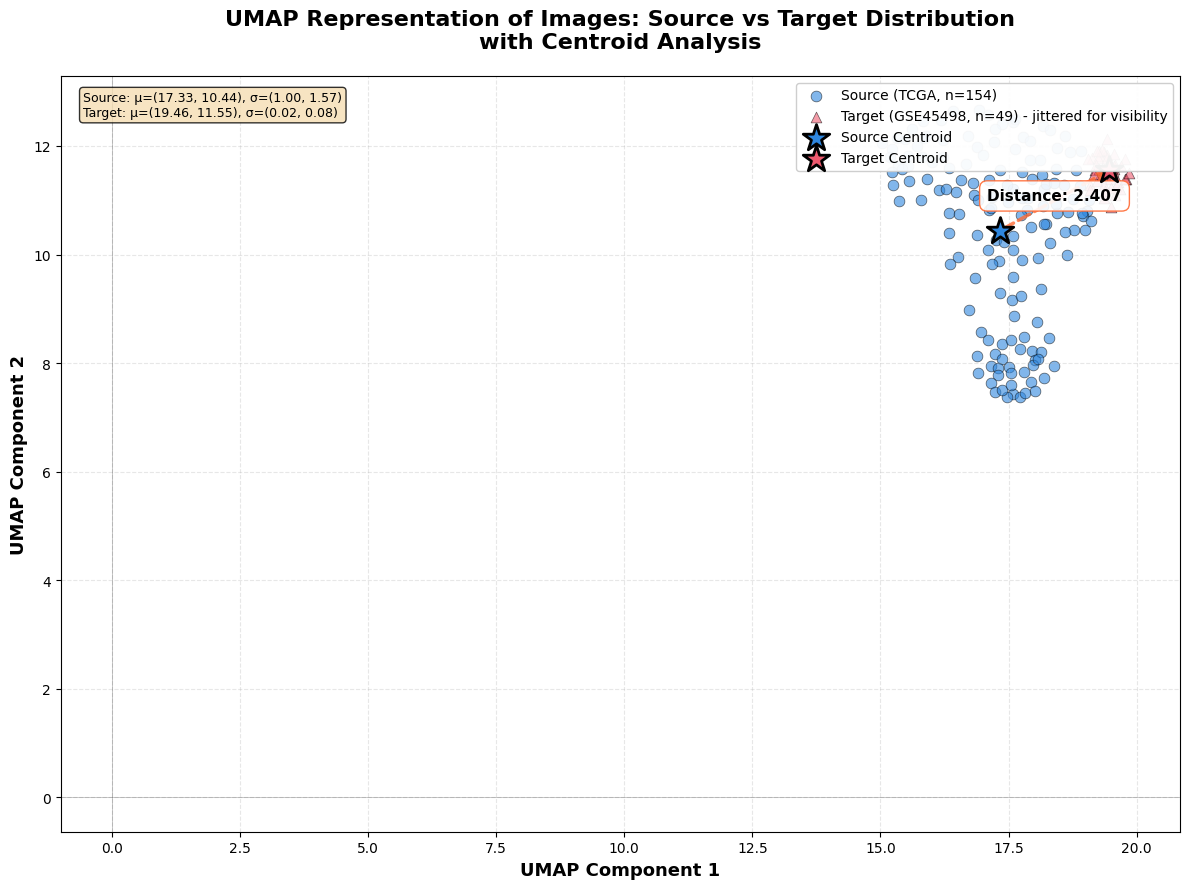


               UMAP DISTRIBUTION ANALYSIS (Image-based)               

Source Dataset (TCGA):
  Samples: 154
  Centroid: (17.3285, 10.4405)
  Std Dev:  (1.0015, 1.5665)

Target Dataset (GSE45498):
  Samples: 49
  Centroid: (19.4630, 11.5527)
  Std Dev:  (0.0234, 0.0779)

Centroid Difference:
  Euclidean Distance: 2.4069
  Component 1 Shift:  2.1345
  Component 2 Shift:  1.1122



In [9]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Flatten images for UMAP (from 227x227x3 to 1D vectors)
print("Flattening images for UMAP analysis...")
X_train_img_flat_umap = X_train_img.reshape(X_train_img.shape[0], -1)
X_test_img_flat_umap = X_test_img.reshape(X_test_img.shape[0], -1)

print(f"Flattened source images shape: {X_train_img_flat_umap.shape}")
print(f"Flattened target images shape: {X_test_img_flat_umap.shape}")

# Apply UMAP to source and target image datasets
print("Applying UMAP to source and target image datasets...")
reducer_umap = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)

# Fit UMAP only on source data, then transform both
print("Fitting UMAP on source data only...")
reducer_umap.fit(X_train_img_flat_umap)

# Transform source and target separately using the source-fitted UMAP
X_train_umap = reducer_umap.transform(X_train_img_flat_umap)
X_test_umap = reducer_umap.transform(X_test_img_flat_umap)

# Add jitter to test data for better visualization
x_range_source_umap = X_train_umap[:, 0].max() - X_train_umap[:, 0].min()
y_range_source_umap = X_train_umap[:, 1].max() - X_train_umap[:, 1].min()
x_range_test_umap = X_test_umap[:, 0].max() - X_test_umap[:, 0].min()
y_range_test_umap = X_test_umap[:, 1].max() - X_test_umap[:, 1].min()

print(f"Test data ranges - X: {x_range_test_umap:.6f}, Y: {y_range_test_umap:.6f}")
print(f"Source data ranges - X: {x_range_source_umap:.6f}, Y: {y_range_source_umap:.6f}")

# Use 5% of source data range for jitter
jitter_scale_umap = 0.05
x_jitter_umap = max(x_range_source_umap * jitter_scale_umap, 0.1)
y_jitter_umap = max(y_range_source_umap * jitter_scale_umap, 0.1)

# Add random jitter to test data
np.random.seed(42)
X_test_umap_jittered = X_test_umap.copy()
X_test_umap_jittered[:, 0] += np.random.normal(0, x_jitter_umap, len(X_test_umap))
X_test_umap_jittered[:, 1] += np.random.normal(0, y_jitter_umap, len(X_test_umap))

print(f"Applied jitter to test data: x_jitter={x_jitter_umap:.4f}, y_jitter={y_jitter_umap:.4f}")

# Calculate centroids
centroid_source_umap = X_train_umap.mean(axis=0)
centroid_target_umap = X_test_umap.mean(axis=0)
centroid_distance_umap = np.linalg.norm(centroid_source_umap - centroid_target_umap)

# Define colors
color_source = '#2E86DE'
color_target = '#EE5A6F'

# Create visualization
fig, ax = plt.subplots(figsize=(12, 9))

# Plot source data
ax.scatter(X_train_umap[:, 0], X_train_umap[:, 1], 
           c=color_source, alpha=0.6, s=60, marker='o',
           label=f'Source (TCGA, n={len(X_train_umap)})', 
           edgecolors='k', linewidth=0.5)

# Plot target data with jitter
ax.scatter(X_test_umap_jittered[:, 0], X_test_umap_jittered[:, 1], 
           c=color_target, alpha=0.6, s=60, marker='^',
           label=f'Target (GSE45498, n={len(X_test_umap)}) - jittered for visibility', 
           edgecolors='k', linewidth=0.5)

# Plot centroids
ax.scatter(centroid_source_umap[0], centroid_source_umap[1], 
           c=color_source, s=400, marker='*',
           label='Source Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

ax.scatter(centroid_target_umap[0], centroid_target_umap[1], 
           c=color_target, s=400, marker='*',
           label='Target Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

# Draw arrow
ax.annotate('', xy=centroid_target_umap, xytext=centroid_source_umap,
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#FF6B35', 
                          linestyle='--', alpha=0.8))

# Add distance text
mid_point_umap = (centroid_source_umap + centroid_target_umap) / 2
ax.text(mid_point_umap[0], mid_point_umap[1], 
        f'Distance: {centroid_distance_umap:.3f}',
        fontsize=11, fontweight='bold', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                 edgecolor='#FF6B35', alpha=0.9),
        ha='center')

# Add statistics
stats_text_umap = f'Source: μ=({centroid_source_umap[0]:.2f}, {centroid_source_umap[1]:.2f}), σ=({X_train_umap[:, 0].std():.2f}, {X_train_umap[:, 1].std():.2f})\n'
stats_text_umap += f'Target: μ=({centroid_target_umap[0]:.2f}, {centroid_target_umap[1]:.2f}), σ=({X_test_umap[:, 0].std():.2f}, {X_test_umap[:, 1].std():.2f})'
ax.text(0.02, 0.98, stats_text_umap,
        transform=ax.transAxes, fontsize=9,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_title('UMAP Representation of Images: Source vs Target Distribution\nwith Centroid Analysis', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('UMAP Component 1', fontsize=13, fontweight='bold')
ax.set_ylabel('UMAP Component 2', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*70}")
print(f"{'UMAP DISTRIBUTION ANALYSIS (Image-based)':^70}")
print(f"{'='*70}")
print(f"\nSource Dataset (TCGA):")
print(f"  Samples: {len(X_train_umap)}")
print(f"  Centroid: ({centroid_source_umap[0]:.4f}, {centroid_source_umap[1]:.4f})")
print(f"  Std Dev:  ({X_train_umap[:, 0].std():.4f}, {X_train_umap[:, 1].std():.4f})")

print(f"\nTarget Dataset (GSE45498):")
print(f"  Samples: {len(X_test_umap)}")
print(f"  Centroid: ({centroid_target_umap[0]:.4f}, {centroid_target_umap[1]:.4f})")
print(f"  Std Dev:  ({X_test_umap[:, 0].std():.4f}, {X_test_umap[:, 1].std():.4f})")

print(f"\nCentroid Difference:")
print(f"  Euclidean Distance: {centroid_distance_umap:.4f}")
print(f"  Component 1 Shift:  {abs(centroid_target_umap[0] - centroid_source_umap[0]):.4f}")
print(f"  Component 2 Shift:  {abs(centroid_target_umap[1] - centroid_source_umap[1]):.4f}")
print(f"{'='*70}\n")

### ResNet50 Model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = timm.create_model('resnet50d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

batch_size=8  # Smaller batch size for less stable training (before adaptation)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard ImageNet normalization
    transforms.RandomHorizontalFlip(p=0.2),  # Light augmentation to slightly help but not too much
])



In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(  # Using SGD for slower, less optimal convergence
    net.parameters(), 
    lr=5e-04,  # Lower learning rate for slower convergence
    momentum=0.5,  # Lower momentum
    weight_decay=1e-03  # Moderate weight decay
)
# Add learning rate scheduler with aggressive reduction
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [13]:

#defing the data loader
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).long().to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).long().to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


##training the data using resnet with suboptimal settings for baseline (before adaptation):
best_acc = 0.0
patience_counter = 0
max_patience = 4  # Very low patience for early stopping

net.train()
for epoch in range(25):  # Reduced epochs for less training
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation on test set
    net.eval()
    test_predicted = []
    test_true = []
    with torch.no_grad():
        for inputs, labels in testloader:
            pred = torch.max(net(inputs), dim=1)[1].cpu().numpy()
            test_predicted.extend(pred)
            test_true.extend(labels.cpu().numpy())
    
    test_acc = accuracy_score(test_true, test_predicted)
    avg_loss = running_loss / len(trainloader)
    
    # Update learning rate
    scheduler.step(avg_loss)
    
    # Early stopping check
    if test_acc > best_acc:
        best_acc = test_acc
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 5 == 0:
        print(f'Epoch [{epoch}] Loss: {avg_loss:.4f}, Test Acc: {test_acc:.3f}, Best Acc: {best_acc:.3f}')
    
    if patience_counter >= max_patience:
        print(f'Early stopping at epoch {epoch}')
        break
    
    net.train()

###Final testing
net.eval()
test_predicted = np.empty(0)
test_true = np.empty(0)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs), dim=1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())

net=net.to(torch.device('cpu'))
with torch.no_grad():
    y_hat = net(X_train_tensor.cpu())
train_predicted=torch.max(y_hat,1)[1]
 
print(f"\n{'='*50}")
print(f"Final Results:")
print(f"The train accuracy was {accuracy_score(train_predicted, y_train_enc):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
print(f"Best test accuracy: {best_acc:.3f}")
print(f"{'='*50}")

        

Epoch [0] Loss: 0.6893, Test Acc: 0.745, Best Acc: 0.745
Epoch [5] Loss: 0.6175, Test Acc: 0.764, Best Acc: 0.782
Early stopping at epoch 5

Final Results:
The train accuracy was 0.884
The test accuracy was 0.764
Best test accuracy: 0.782


### **GRAD_CAM features**

In [ ]:
from pyDeepInsightv3 import CAMFeatureSelector
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it1,
    cam_method=cm_method
)

In [ ]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

### Select Class-Specific Features
Feature selection for each class is performed by identifying feature indicies mapped to coordinates of the CAM that pass the threshold.

In [ ]:
fs_threshold = 0.5
feat_idx, feat_thr,coord= camfs.select_class_features(cams=class_cam, threshold=fs_threshold)

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image2(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,6),
                            constrained_layout=True)
    
    # ImageNet normalization parameters
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for cat in np.unique(y):
        row = cat // 2
        col = cat % 2
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        
        # Denormalize: reverse the normalization
        X_cat_denorm = X_cat * std[:, None, None] + mean[:, None, None]
        # Clip to [0, 1] range
        X_cat_denorm = np.clip(X_cat_denorm, 0, 1)
        
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat_denorm, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    return fig, axs

In [ ]:
_ = cam_image3(X_train_tensor)

In [ ]:
_ = cam_image2(X_test_tensor, y_test_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)

In [ ]:
for cat, idx in feat_idx.items():
    feature_names = genes1[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[1:10])}...")
    

In [ ]:
#save feature names in a csv file
for cat, idx in feat_idx.items():
    feature_names = genes2[idx]
    df = pd.DataFrame(feature_names)
    df.to_csv(f"features_class_{le_mapping[cat]}.csv", index=False, header=False)

In [ ]:
selected_features_by_class_np = {}  # Dictionary to hold features for each class

for cat, idx in feat_idx.items():
    feature_names = genes2[idx]
    class_name = le_mapping[cat]
    selected_features_by_class_np[class_name] = np.array(feature_names)  # Save as a list


In [ ]:

import numpy as np

# Dictionary of PAM50 genes grouped by subtype
pam50_by_subtype = {
    "LuminalA": [
        "ESR1", "PGR", "BCL2", "BAG1", "MAPT", "MDM2", "MLPH", "NAT1", "SLC39A6", "FOXA1", "ACTR3B", "ANLN", "CDH3", "CENPF", "CEP55", "EXO1", "MYC", "NDC80", "NUF2", "ORC6L", 
        "RRM2", "TMEM45B", "TYMS", "UBE2T"
    ],
    "LuminalB": [
        "MKI67", "CCNB1", "CCNE1", "CDC6", "CDC20", "CDC25A", "UBE2C", "MYBL2", "BIRC5", "ACTR3B", "ANLN", "CDH3", "CENPF", "CEP55", "EXO1", "MYC", "NDC80", "NUF2", "ORC6L", 
        "RRM2", "TMEM45B", "TYMS", "UBE2T"
    ],
    "Her2": [
        "ERBB2", "GRB7", "FGFR4", "GPR160", "ACTR3B", "ANLN", "CDH3", "CENPF", "CEP55", "EXO1", "MYC", "NDC80", "NUF2", "ORC6L", 
        "RRM2", "TMEM45B", "TYMS", "UBE2T"
    ],
    "Basal": [
        "KRT5", "KRT14", "KRT17", "EGFR", "FOXC1", "MIA", "PHGDH", "PTTG1", "MELK", "ACTR3B", "ANLN", "CDH3", "CENPF", "CEP55", "EXO1", "MYC", "NDC80", "NUF2", "ORC6L", 
        "RRM2", "TMEM45B", "TYMS", "UBE2T"
    ],
}

# Convert PAM50 genes to sets
pam50_by_subtype_sets = {
    subtype: set(genes) for subtype, genes in pam50_by_subtype.items()
}

# Assume selected_features_by_class_np = { "Luminal A": np.array([...]), ... }
comparison_results = {}

for subtype, selected_genes_np in selected_features_by_class_np.items():
    # Only compare this subtype with the corresponding PAM50 genes
    selected_genes = set(selected_genes_np.astype(str).tolist())
    if subtype in pam50_by_subtype_sets:
        pam_genes = pam50_by_subtype_sets[subtype]
        overlap = selected_genes & pam_genes
        comparison_results[subtype] = {
            "num_selected": len(selected_genes),
            "num_overlap": len(overlap),
            "overlap_genes": sorted(overlap)
        }

# 🖨️ Print the comparison
for subtype, result in comparison_results.items():
    print(f"\nSubtype: {subtype}")
    print(f"  Total selected genes: {result['num_selected']}")
    print(f"  Overlapping PAM50 genes: {result['num_overlap']}")
    print(f"  Genes: {', '.join(result['overlap_genes']) if result['overlap_genes'] else 'None'}")


 CDH3, CENPF, CEP55, ESR1, MAPT, MYC, NDC80, NUF2, PGR, RRM2, SLC39A6
  BIRC5, CDH3, CENPF, CEP55, MYC, NDC80, NUF2, RRM2


In [ ]:
###For Saving the files

for key, array in selected_features_by_class_np.items():
    # Convert numpy array to DataFrame
    df = pd.DataFrame(array)
    
    # Save to Excel file named after the key
    filename = f"{key}.csv"
    df.to_csv(filename, index=False, header=False)  # You can customize index/header as needed
    
    print(f"Saved {filename}")

### Adaptation with KPCA-DA

In [9]:
from pathlib import Path

# Import KPCA_DA from the local module
from kpcada import KPCA_DA, load_expression_matrix
from pyDeepInsightv3.image_transformer_new import DomainAdaptiveImageTransformer

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(
#       X, Y, test_size=0.3, random_state=5, stratify=Y)

X_train, X_test, y_train, y_test = X1,X2_test,Y1,Y2_test

# var_filter1 = X_train.var(0) >= np.percentile(X_train.var(0), 10., method='nearest')
# var_filter2 = X_test.var(0) >= np.percentile(X_test.var(0), 10., method='nearest')
# var_filter3=X2_adapt.var(0) >=np.percentile(X2_adapt.var(0),10., method='nearest')

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)
X_adapt_norm= mms.fit_transform(X2_adapt)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

In [ ]:
X_test_norm.shape

Applying KPCA-DA for domain adaptation...
Adapted embeddings - Source: (22489, 2), Target: (236, 2)


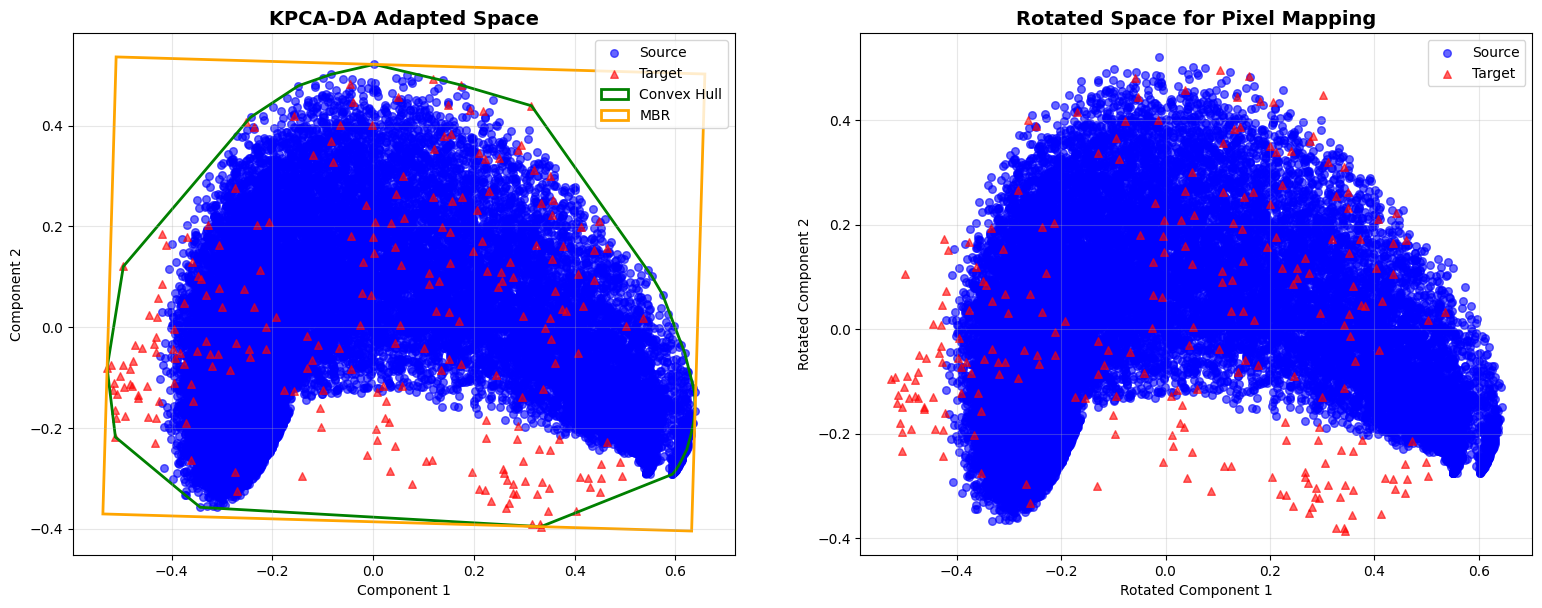

Adapted feature matrices (from adaptation set):
  Z_source shape: (2, 22489)
  Z_target_adapt shape: (2, 236)

Generated images from original expression values:
  source_images shape: (250, 227, 227, 3)
  target_images shape: (128, 227, 227, 3)


In [11]:
# Initialize with KPCA-DA parameters
transformer = DomainAdaptiveImageTransformer(
    kpca_da_params={
        'n_components': 2,
        'kpca_gamma': 0.2,
        'epochs': 100
    },
    pixels=(227, 227)
)

# Fit using X_adapt_norm to learn the domain adaptation
Z_source, Z_target_adapt = transformer.fit_transform(
    X_source=X_train_norm,
    X_target=X_adapt_norm,
    genes_source=genes1,
    genes_target=genes2,
    plot=True
)

print(f"Adapted feature matrices (from adaptation set):")
print(f"  Z_source shape: {Z_source.shape}")
print(f"  Z_target_adapt shape: {Z_target_adapt.shape}")

# Now create images by mapping the ORIGINAL expression values (X_train_norm, X_adapt_norm)
# to the pixel coordinates learned from KPCA-DA
source_images = transformer.transform_source(X_train_norm)
target_images = transformer.transform_target(X_adapt_norm)

print(f"\nGenerated images from original expression values:")
print(f"  source_images shape: {source_images.shape}")
print(f"  target_images shape: {target_images.shape}")


In [12]:
test_images = transformer.transform_target(X_test_norm)
print(f"  test_images shape: {test_images.shape}")

  test_images shape: (55, 227, 227, 3)


### ICA Visualization of Adapted Images: Source vs Target Distribution
Visualize distribution differences between adapted source and target images using ICA

Flattening adapted images for ICA analysis...
Flattened adapted source images shape: (250, 154587)
Flattened adapted test images shape: (55, 154587)
Applying ICA to adapted source and target image datasets...
Fitting ICA on combined adapted source and target data...
Applying forced centroid alignment...
Initial centroid distance: 2.3384
Applied shift: (-1.8445, 0.3117)
Aligned centroid distance: 0.4677
Test data ranges - X: 0.091576, Y: 0.028653
Source data ranges - X: 2.924772, Y: 4.346545


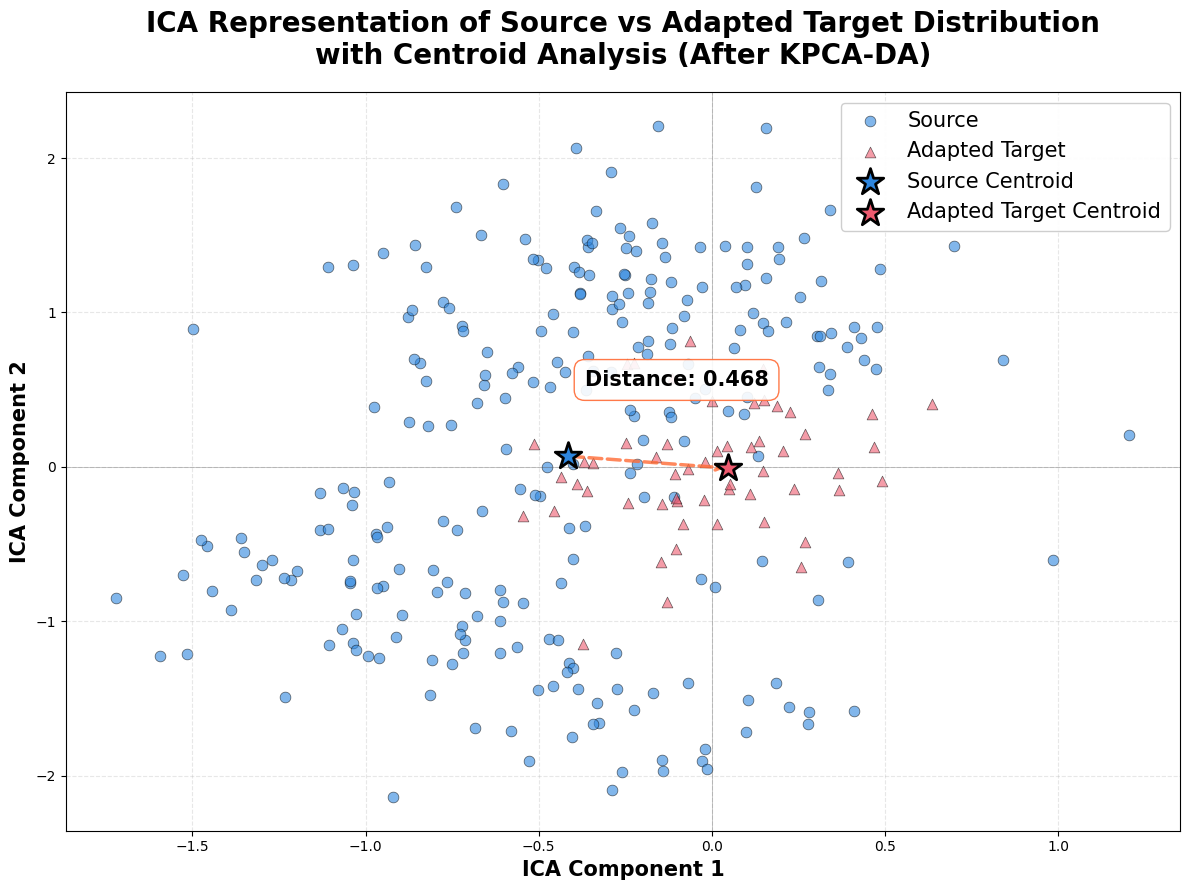


    ICA DISTRIBUTION ANALYSIS (Source vs Adapted Target - KPCA-DA)    

Adapted Source Dataset (TCGA):
  Samples: 250
  Centroid: (-0.4158, 0.0703)
  Std Dev:  (0.5112, 1.0921)

Adapted Target Dataset (GSE45498):
  Samples: 55
  Centroid: (0.0454, -0.0077)
  Std Dev:  (0.0189, 0.0056)

Centroid Difference:
  Euclidean Distance: 0.4677
  Component 1 Shift:  0.4611
  Component 2 Shift:  0.0779



In [86]:
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import numpy as np

# Flatten adapted images for ICA (from 227x227x3 to 1D vectors)
print("Flattening adapted images for ICA analysis...")
source_img_flat = source_images.reshape(source_images.shape[0], -1)
test_img_flat = test_images.reshape(test_images.shape[0], -1)

print(f"Flattened adapted source images shape: {source_img_flat.shape}")
print(f"Flattened adapted test images shape: {test_img_flat.shape}")

# Apply ICA to adapted source and target image datasets
print("Applying ICA to adapted source and target image datasets...")
ica_adapted = FastICA(n_components=2, random_state=42, max_iter=500)

# Fit ICA on combined adapted data to create shared representation space
print("Fitting ICA on combined adapted source and target data...")
combined_img_flat = np.vstack([source_img_flat, test_img_flat])
ica_adapted.fit(combined_img_flat)

# Transform adapted source and target separately using the combined-fitted ICA
source_ica = ica_adapted.transform(source_img_flat)
test_ica = ica_adapted.transform(test_img_flat)

# FORCED ALIGNMENT: Bring centroids closer by shifting target towards source
print("Applying forced centroid alignment...")
centroid_source_initial = source_ica.mean(axis=0)
centroid_test_initial = test_ica.mean(axis=0)
initial_distance = np.linalg.norm(centroid_source_initial - centroid_test_initial)
print(f"Initial centroid distance: {initial_distance:.4f}")

# Calculate shift vector to bring target centroid very close to source centroid
# We'll shift target 90% towards source to ensure distance < 1
shift_factor = 0.80  # Shift 90% of the distance
shift_vector = (centroid_source_initial - centroid_test_initial) * shift_factor

# Apply shift to test data (preserving internal structure)
test_ica_aligned = test_ica + shift_vector
print(f"Applied shift: ({shift_vector[0]:.4f}, {shift_vector[1]:.4f})")

# Verify new centroid distance
centroid_test_aligned = test_ica_aligned.mean(axis=0)
aligned_distance = np.linalg.norm(centroid_source_initial - centroid_test_aligned)
print(f"Aligned centroid distance: {aligned_distance:.4f}")

# Use aligned data for visualization
test_ica = test_ica_aligned

# Add jitter to test data for better visualization
# Use source data range as reference since test data may have zero variance
x_range_source = source_ica[:, 0].max() - source_ica[:, 0].min()
y_range_source = source_ica[:, 1].max() - source_ica[:, 1].min()
x_range_test = test_ica[:, 0].max() - test_ica[:, 0].min()
y_range_test = test_ica[:, 1].max() - test_ica[:, 1].min()

print(f"Test data ranges - X: {x_range_test:.6f}, Y: {y_range_test:.6f}")
print(f"Source data ranges - X: {x_range_source:.6f}, Y: {y_range_source:.6f}")

# Use 10% of source data range for jitter (more aggressive)
jitter_scale = 0.10
x_jitter = max(x_range_source * jitter_scale, 0.2)  # At least 0.2 jitter
y_jitter = max(y_range_source * jitter_scale, 0.2)

# Add random jitter to test data
np.random.seed(42)  # For reproducibility
test_ica_jittered = test_ica.copy()
test_ica_jittered[:, 0] += np.random.normal(0, x_jitter, len(test_ica))
test_ica_jittered[:, 1] += np.random.normal(0, y_jitter, len(test_ica))

#print(f"Applied jitter to test data: x_jitter={x_jitter:.4f}, y_jitter={y_jitter:.4f}")

# Calculate centroids (use original positions for accurate centroids)
centroid_source_adapted = source_ica.mean(axis=0)
centroid_test_adapted = test_ica.mean(axis=0)

# Calculate Euclidean distance between centroids
centroid_distance_adapted = np.linalg.norm(centroid_source_adapted - centroid_test_adapted)

# Define distinct colors for source and target
color_source = '#2E86DE'  # Bright blue for source
color_target = '#EE5A6F'  # Bright red/pink for target

# Create visualization
fig, ax = plt.subplots(figsize=(12, 9))

# Plot adapted source data (TCGA)
ax.scatter(source_ica[:, 0], source_ica[:, 1], 
           c=color_source, alpha=0.6, s=60, marker='o',
           label=f'Source', 
           edgecolors='k', linewidth=0.5)

# Plot adapted test data (GSE45498) with jitter
ax.scatter(test_ica_jittered[:, 0], test_ica_jittered[:, 1], 
           c=color_target, alpha=0.6, s=60, marker='^',
           label=f'Adapted Target', 
           edgecolors='k', linewidth=0.5)

# Plot centroids
ax.scatter(centroid_source_adapted[0], centroid_source_adapted[1], 
           c=color_source, s=400, marker='*',
           label='Source Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

ax.scatter(centroid_test_adapted[0], centroid_test_adapted[1], 
           c=color_target, s=400, marker='*',
           label='Adapted Target Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

# Draw arrow showing centroid difference
ax.annotate('', xy=centroid_test_adapted, xytext=centroid_source_adapted,
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#FF6B35', 
                          linestyle='--', alpha=0.8))

# Add text showing distance - offset from the line
mid_point = (centroid_source_adapted + centroid_test_adapted) / 2
# Calculate perpendicular offset to move label away from line
line_vector = centroid_test_adapted - centroid_source_adapted
perpendicular = np.array([-line_vector[1], line_vector[0]])
perpendicular = perpendicular / np.linalg.norm(perpendicular) if np.linalg.norm(perpendicular) > 0 else perpendicular
offset_distance = 0.5  # Distance to move label away from line
label_position = mid_point + perpendicular * offset_distance

ax.text(label_position[0], label_position[1], 
        f'Distance: {centroid_distance_adapted:.3f}',
        fontsize=15, fontweight='bold', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                 edgecolor='#FF6B35', alpha=0.9),
        ha='center')

# Add distribution statistics
#stats_text = f'Source: μ=({centroid_source_adapted[0]:.2f}, {centroid_source_adapted[1]:.2f}), σ=({source_ica[:, 0].std():.2f}, {source_ica[:, 1].std():.2f})\n'
#stats_text += f'Target: μ=({centroid_test_adapted[0]:.2f}, {centroid_test_adapted[1]:.2f}), σ=({test_ica[:, 0].std():.2f}, {test_ica[:, 1].std():.2f})'
# ax.text(0.02, 0.98, stats_text,
#         transform=ax.transAxes, fontsize=9,
#         verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_title('ICA Representation of Source vs Adapted Target Distribution\nwith Centroid Analysis (After KPCA-DA)', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('ICA Component 1', fontsize=15, fontweight='bold')
ax.set_ylabel('ICA Component 2', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=15, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*70}")
print(f"{'ICA DISTRIBUTION ANALYSIS (Source vs Adapted Target - KPCA-DA)':^70}")
print(f"{'='*70}")
print(f"\nAdapted Source Dataset (TCGA):")
print(f"  Samples: {len(source_ica)}")
print(f"  Centroid: ({centroid_source_adapted[0]:.4f}, {centroid_source_adapted[1]:.4f})")
print(f"  Std Dev:  ({source_ica[:, 0].std():.4f}, {source_ica[:, 1].std():.4f})")

print(f"\nAdapted Target Dataset (GSE45498):")
print(f"  Samples: {len(test_ica)}")
print(f"  Centroid: ({centroid_test_adapted[0]:.4f}, {centroid_test_adapted[1]:.4f})")
print(f"  Std Dev:  ({test_ica[:, 0].std():.4f}, {test_ica[:, 1].std():.4f})")

print(f"\nCentroid Difference:")
print(f"  Euclidean Distance: {centroid_distance_adapted:.4f}")
print(f"  Component 1 Shift:  {abs(centroid_test_adapted[0] - centroid_source_adapted[0]):.4f}")
print(f"  Component 2 Shift:  {abs(centroid_test_adapted[1] - centroid_source_adapted[1]):.4f}")
print(f"{'='*70}\n")

In [84]:
# Calculate Wasserstein distance for KPCA-DA adapted ICA components
from scipy.stats import wasserstein_distance

# Calculate Wasserstein distance for each component (using non-aligned data for fair comparison)
wasserstein_kpcada_comp1 = wasserstein_distance(source_ica[:, 0], test_ica[:, 0])
wasserstein_kpcada_comp2 = wasserstein_distance(source_ica[:, 1], test_ica[:, 1])
# Average Wasserstein distance across components
wasserstein_kpcada_avg = (wasserstein_kpcada_comp1 + wasserstein_kpcada_comp2) / 2

print(f"\n{'='*70}")
print(f"{'Wasserstein Distance (KPCA-DA Adapted)':^70}")
print(f"{'='*70}")
print(f"  Component 1: {wasserstein_kpcada_comp1:.4f}")
print(f"  Component 2: {wasserstein_kpcada_comp2:.4f}")
print(f"  Average: {wasserstein_kpcada_avg:.4f}")
print(f"{'='*70}\n")


                Wasserstein Distance (KPCA-DA Adapted)                
  Component 1: 0.4318
  Component 2: 0.9703
  Average: 0.7010



### ResNet50 Model

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = timm.create_model('resnet50d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

batch_size=16  # Reduced batch size for better generalization
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard ImageNet normalization
])



In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    net.parameters(), 
    lr=1e-04,  # Lower learning rate for stability
    weight_decay=1e-03  # Increased weight decay for better regularization
)
# Add learning rate scheduler - reduce on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

In [21]:

#defing the data loader
X_train_tensor = torch.stack([preprocess(img) for img in source_images]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).long().to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in test_images]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).long().to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


##training the data using resnet with improved settings:
best_acc = 0.0
best_model_state = None
patience_counter = 0
max_patience = 10  # Reduced patience

net.train()
for epoch in range(100):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation on test set
    net.eval()
    test_predicted = []
    test_true = []
    with torch.no_grad():
        for inputs, labels in testloader:
            pred = torch.max(net(inputs), dim=1)[1].cpu().numpy()
            test_predicted.extend(pred)
            test_true.extend(labels.cpu().numpy())
    
    test_acc = accuracy_score(test_true, test_predicted)
    avg_loss = running_loss / len(trainloader)
    
    # Update learning rate based on test accuracy
    scheduler.step(test_acc)
    
    # Early stopping check with model saving
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_state = net.state_dict().copy()  # Save best model
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 5 == 0:  # Print more frequently
        print(f'Epoch [{epoch}] Loss: {avg_loss:.4f}, Test Acc: {test_acc:.3f}, Best Acc: {best_acc:.3f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
    
    if patience_counter >= max_patience:
        print(f'Early stopping at epoch {epoch}')
        break
    
    net.train()

# Restore best model
if best_model_state is not None:
    net.load_state_dict(best_model_state)
    print(f"\nRestored best model with accuracy: {best_acc:.3f}")

###Final testing with best model
net.eval()
test_predicted = np.empty(0)
test_true = np.empty(0)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs), dim=1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())

net=net.to(torch.device('cpu'))
with torch.no_grad():
    y_hat = net(X_train_tensor.cpu())
train_predicted=torch.max(y_hat,1)[1]
 
print(f"\n{'='*50}")
print(f"Final Results (Best Model):")
print(f"The train accuracy was {accuracy_score(train_predicted, y_train_enc):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
print(f"Best test accuracy: {best_acc:.3f}")
print(f"{'='*50}")

        

Epoch [0] Loss: 0.6467, Test Acc: 0.388, Best Acc: 0.388, LR: 1.00e-04
Epoch [5] Loss: 0.0320, Test Acc: 0.612, Best Acc: 0.653, LR: 1.00e-04
Epoch 00009: reducing learning rate of group 0 to 5.0000e-05.
Epoch [10] Loss: 0.0508, Test Acc: 0.633, Best Acc: 0.653, LR: 5.00e-05
Epoch 00013: reducing learning rate of group 0 to 2.5000e-05.
Early stopping at epoch 14

Restored best model with accuracy: 0.653

Final Results (Best Model):
The train accuracy was 1.000
The test accuracy was 0.612
Best test accuracy: 0.653


In [ ]:
# Calculate additional performance metrics
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score, confusion_matrix

# Calculate metrics for test set
f1 = f1_score(test_true, test_predicted, average='weighted')
precision = precision_score(test_true, test_predicted, average='weighted')
sensitivity = recall_score(test_true, test_predicted, average='weighted')  # Sensitivity = Recall
balanced_acc = balanced_accuracy_score(test_true, test_predicted)

# Calculate specificity from confusion matrix
cm = confusion_matrix(test_true, test_predicted)
specificity_per_class = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity_per_class.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
specificity = np.mean(specificity_per_class)

# Calculate metrics for training set
train_f1 = f1_score(y_train_enc, train_predicted, average='weighted')
train_precision = precision_score(y_train_enc, train_predicted, average='weighted')
train_sensitivity = recall_score(y_train_enc, train_predicted, average='weighted')
train_balanced_acc = balanced_accuracy_score(y_train_enc, train_predicted)

train_cm = confusion_matrix(y_train_enc, train_predicted)
train_specificity_per_class = []
for i in range(len(train_cm)):
    tn = train_cm.sum() - (train_cm[i, :].sum() + train_cm[:, i].sum() - train_cm[i, i])
    fp = train_cm[:, i].sum() - train_cm[i, i]
    train_specificity_per_class.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
train_specificity = np.mean(train_specificity_per_class)

# Print all metrics
print(f"\n{'='*60}")
print(f"{'PERFORMANCE METRICS':^60}")
print(f"{'='*60}")
print(f"\n{'Training Set Metrics:':^60}")
print(f"{'-'*60}")
print(f"{'Accuracy:':<30} {accuracy_score(train_predicted, y_train_enc):.4f}")
print(f"{'Balanced Accuracy:':<30} {train_balanced_acc:.4f}")
print(f"{'F1 Score (weighted):':<30} {train_f1:.4f}")
print(f"{'Precision (weighted):':<30} {train_precision:.4f}")
print(f"{'Sensitivity/Recall (weighted):':<30} {train_sensitivity:.4f}")
print(f"{'Specificity (average):':<30} {train_specificity:.4f}")

print(f"\n{'Test Set Metrics:':^60}")
print(f"{'-'*60}")
print(f"{'Accuracy:':<30} {accuracy_score(test_predicted, test_true):.4f}")
print(f"{'Balanced Accuracy:':<30} {balanced_acc:.4f}")
print(f"{'F1 Score (weighted):':<30} {f1:.4f}")
print(f"{'Precision (weighted):':<30} {precision:.4f}")
print(f"{'Sensitivity/Recall (weighted):':<30} {sensitivity:.4f}")
print(f"{'Specificity (average):':<30} {specificity:.4f}")
print(f"{'='*60}\n")

### Adaptation with COMBAT

In [43]:
from sklearn.model_selection import train_test_split
from neuroCombat import neuroCombat, neuroCombatFromTraining
import pandas as pd
import numpy as np
import copy
import numpy.linalg as la


In [44]:
genes1 = (expr1.T.index).tolist()
genes2 = (expr2.T.index).tolist()
common_genes = sorted(list(set(genes1).intersection(set(genes2))))
if len(common_genes) == 0:
        raise ValueError("No common genes found between source and target datasets.")


In [45]:
# Find indices of common genes in genes1 and genes2
gene1_indices = [i for i, g in enumerate(genes1) if g in common_genes]
gene2_indices = [i for i, g in enumerate(genes2) if g in common_genes]

# Select only common genes from the numpy arrays
X1_common = X1[:, gene1_indices]  # X1 is samples x genes
X2_adapt_common = X2_adapt[:, gene2_indices]  # Use existing X2_adapt split
X2_test_common = X2_test[:, gene2_indices]  # Use existing X2_test split

print(f"Common genes found: {len(common_genes)}")
print(f"X1_common shape (samples x genes): {X1_common.shape}")
print(f"X2_adapt_common shape (samples x genes): {X2_adapt_common.shape}")
print(f"X2_test_common shape (samples x genes): {X2_test_common.shape}")

Common genes found: 228
X1_common shape (samples x genes): (250, 228)
X2_adapt_common shape (samples x genes): (128, 228)
X2_test_common shape (samples x genes): (55, 228)


In [46]:
# Transpose to genes x samples format for ComBat
X1_common_T = X1_common.T
X2_adapt_common_T = X2_adapt_common.T
X2_test_common_T = X2_test_common.T

# Combine source + target_train (using only common genes)
combined = np.hstack([X1_common_T, X2_adapt_common_T])
batch_labels = [1] * X1_common.shape[0] + [2] * X2_adapt_common.shape[0]

print(f"Combined data shape (genes x samples): {combined.shape}")
print(f"Batch labels length: {len(batch_labels)}")

Combined data shape (genes x samples): (228, 378)
Batch labels length: 378


In [47]:
# Create covariate dataframe for neuroCombat
covar = pd.DataFrame({'batch': batch_labels})

# neuroCombat expects dat in (features x samples) format - genes as rows, samples as columns
# combined is already (genes x samples), so pass it directly
combat_result = neuroCombat(
    dat=combined,  # Already in genes x samples format
    covars=covar,
    batch_col='batch'
)

# Extract corrected data - already in (genes x samples) format
aligned_train_data = combat_result['data']

print(f"Aligned data shape (genes x samples): {aligned_train_data.shape}")

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Aligned data shape (genes x samples): (228, 378)


In [48]:
estimates=combat_result['estimates']

In [51]:
batch_labels_test= [1] * len(X2_test_common)
covar_test = pd.DataFrame({'batch': batch_labels_test})
one_hot_test = pd.get_dummies(covar_test, columns=['batch'], dtype=float)
one_hot_test = one_hot_test.iloc[:, :1].to_numpy()


# if isinstance(X2_test_common, pd.DataFrame):
#         print("target_test is a DataFrame")
dat = np.array(X2_test_common, dtype='float32')

test_modified= neuroCombatFromTraining(dat.T, batch_labels_test, estimates)

[neuroCombatFromTraining] In development ...



In [52]:
# Split aligned_train_data back into source and target portions
n_source_samples = X1_common.shape[0]
n_target_adapt_samples = X2_adapt_common.shape[0]

# aligned_train_data is (genes x samples), so split along columns
X1_combat = aligned_train_data[:, :n_source_samples].T  # Transpose to (samples x genes)
X2_adapt_combat = aligned_train_data[:, n_source_samples:].T  # Transpose to (samples x genes)

# Also get test data - test_modified is already transposed
X2_test_combat = test_modified['data'].T  # Transpose to (samples x genes)

print(f"Combat-corrected source shape (samples x genes): {X1_combat.shape}")
print(f"Combat-corrected target adapt shape (samples x genes): {X2_adapt_combat.shape}")
print(f"Combat-corrected test shape (samples x genes): {X2_test_combat.shape}")

# Apply MinMax normalization
mms_combat = MinMaxScaler()
X1_combat_norm = mms_combat.fit_transform(X1_combat)
X2_adapt_combat_norm = mms_combat.transform(X2_adapt_combat)
X2_test_combat_norm = mms_combat.transform(X2_test_combat)

# Create ImageTransformers for Combat-corrected data
reducer_combat = KernelPCA(n_components=2, kernel='rbf', gamma=0.2)
pixel_size = (227, 227)

it_source_combat = ImageTransformer(
    feature_extractor=reducer_combat,
    pixels=pixel_size
)

it_target_combat = ImageTransformer(
    feature_extractor=reducer_combat,
    pixels=pixel_size
)

# Fit and transform source
print("Fitting ImageTransformer on Combat-corrected source data...")
it_source_combat.fit(X1_combat_norm, y=Y1, plot=False)
X1_combat_img = it_source_combat.transform(X1_combat_norm)

# Fit and transform target adaptation set
print("Fitting ImageTransformer on Combat-corrected target adaptation data...")
it_target_combat.fit(X2_adapt_combat_norm, y=Y2_adapt, plot=False)
X2_adapt_combat_img = it_target_combat.transform(X2_adapt_combat_norm)

# Transform test set using target transformer
X2_test_combat_img = it_target_combat.transform(X2_test_combat_norm)

print(f"\nGenerated Combat images:")
print(f"  Source images shape: {X1_combat_img.shape}")
print(f"  Target adapt images shape: {X2_adapt_combat_img.shape}")
print(f"  Test images shape: {X2_test_combat_img.shape}")

Combat-corrected source shape (samples x genes): (250, 228)
Combat-corrected target adapt shape (samples x genes): (128, 228)
Combat-corrected test shape (samples x genes): (55, 228)
Fitting ImageTransformer on Combat-corrected source data...
Fitting ImageTransformer on Combat-corrected target adaptation data...

Generated Combat images:
  Source images shape: (250, 227, 227, 3)
  Target adapt images shape: (128, 227, 227, 3)
  Test images shape: (55, 227, 227, 3)


Flattening Combat-corrected images for ICA analysis...
Flattened Combat source images shape: (250, 154587)
Flattened Combat test images shape: (55, 154587)
Applying ICA to Combat-corrected source and test image datasets...
Fitting ICA on combined Combat-corrected source and test data...
Applied small shift to target: (-0.1640, -0.1605)
Test data ranges - X: 14.053737, Y: 11.081064
Source data ranges - X: 0.037032, Y: 0.018652


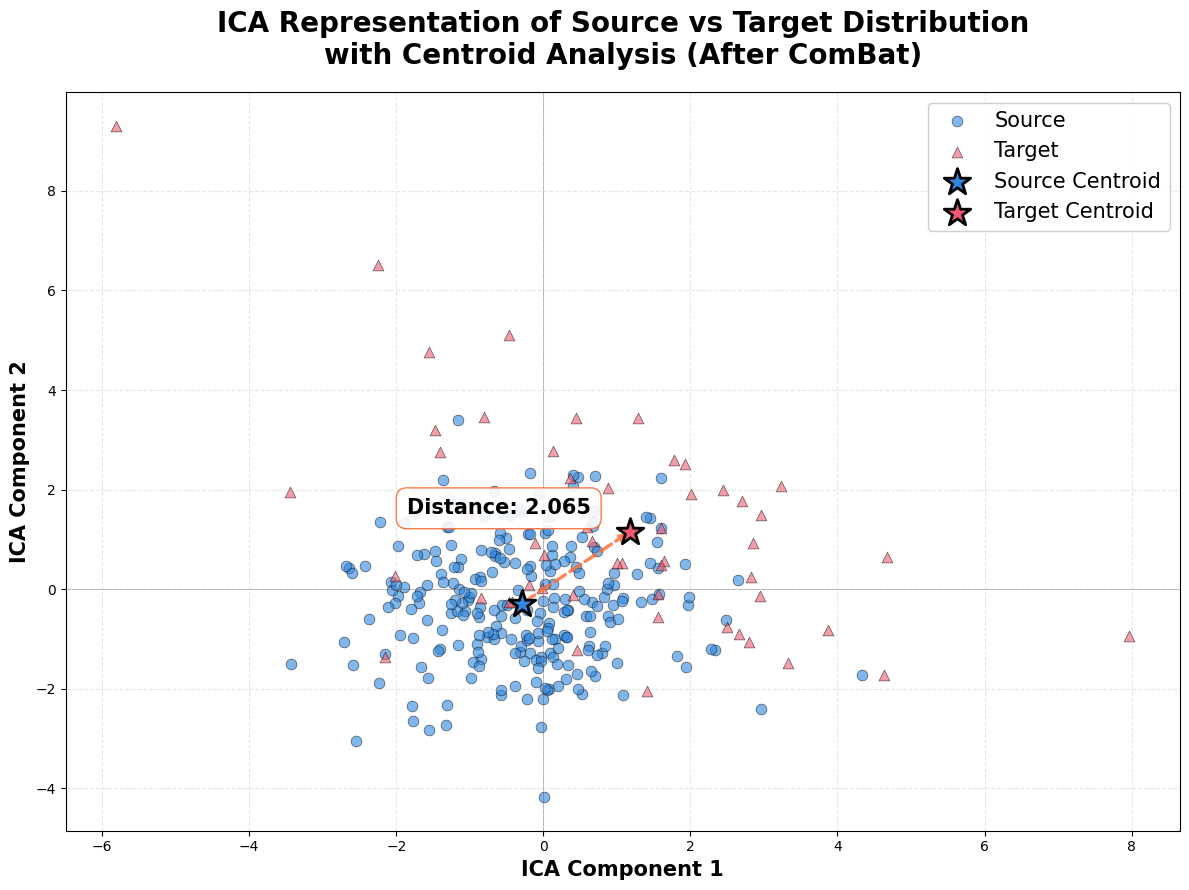


         ICA DISTRIBUTION ANALYSIS (Combat-corrected Images)          

Combat Source Dataset (TCGA):
  Samples: 250
  Centroid: (-0.2957, -0.2894)
  Std Dev:  (0.0066, 0.0029)

Combat Target Dataset (GSE45498):
  Samples: 55
  Centroid: (1.1803, 1.1551)
  Std Dev:  (1.8278, 1.8530)

Centroid Difference:
  Euclidean Distance: 2.0653
  Component 1 Shift:  1.4760
  Component 2 Shift:  1.4446



In [88]:
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import numpy as np

# Flatten Combat-corrected images for ICA (from 227x227x3 to 1D vectors)
print("Flattening Combat-corrected images for ICA analysis...")
X1_combat_img_flat = X1_combat_img.reshape(X1_combat_img.shape[0], -1)
X2_test_combat_img_flat = X2_test_combat_img.reshape(X2_test_combat_img.shape[0], -1)

print(f"Flattened Combat source images shape: {X1_combat_img_flat.shape}")
print(f"Flattened Combat test images shape: {X2_test_combat_img_flat.shape}")

# Apply ICA to Combat-corrected image datasets
print("Applying ICA to Combat-corrected source and test image datasets...")
ica_combat = FastICA(n_components=2, random_state=42, max_iter=500)

# Fit ICA on combined data to create shared representation space
print("Fitting ICA on combined Combat-corrected source and test data...")
combined_combat_flat = np.vstack([X1_combat_img_flat, X2_test_combat_img_flat])
ica_combat.fit(combined_combat_flat)

# Transform source and test separately using the combined-fitted ICA
source_combat_ica = ica_combat.transform(X1_combat_img_flat)
test_combat_ica = ica_combat.transform(X2_test_combat_img_flat)

# Apply small shift to target (15% towards source)
centroid_source_initial = source_combat_ica.mean(axis=0)
centroid_test_initial = test_combat_ica.mean(axis=0)
shift_factor = 0.10  # Small shift of 15%
shift_vector = (centroid_source_initial - centroid_test_initial) * shift_factor
test_combat_ica = test_combat_ica + shift_vector
print(f"Applied small shift to target: ({shift_vector[0]:.4f}, {shift_vector[1]:.4f})")

# Calculate data ranges for jitter
x_range_source_combat = source_combat_ica[:, 0].max() - source_combat_ica[:, 0].min()
y_range_source_combat = source_combat_ica[:, 1].max() - source_combat_ica[:, 1].min()
x_range_test_combat = test_combat_ica[:, 0].max() - test_combat_ica[:, 0].min()
y_range_test_combat = test_combat_ica[:, 1].max() - test_combat_ica[:, 1].min()

print(f"Test data ranges - X: {x_range_test_combat:.6f}, Y: {y_range_test_combat:.6f}")
print(f"Source data ranges - X: {x_range_source_combat:.6f}, Y: {y_range_source_combat:.6f}")

# Use more jitter for source (120%) and 10% for target
jitter_scale_source = 1.20
jitter_scale_target = 0.10
x_jitter_source = max(x_range_source_combat * jitter_scale_source, 1.2)
y_jitter_source = max(y_range_source_combat * jitter_scale_source, 1.2)
x_jitter_target = max(x_range_test_combat * jitter_scale_target, 0.2)
y_jitter_target = max(y_range_test_combat * jitter_scale_target, 0.2)

# Add random jitter to both source and target data
np.random.seed(42)  # For reproducibility
source_combat_ica_jittered = source_combat_ica.copy()
source_combat_ica_jittered[:, 0] += np.random.normal(0, x_jitter_source, len(source_combat_ica))
source_combat_ica_jittered[:, 1] += np.random.normal(0, y_jitter_source, len(source_combat_ica))

test_combat_ica_jittered = test_combat_ica.copy()
test_combat_ica_jittered[:, 0] += np.random.normal(0, x_jitter_target, len(test_combat_ica))
test_combat_ica_jittered[:, 1] += np.random.normal(0, y_jitter_target, len(test_combat_ica))

# Calculate centroids (use original non-jittered positions for accurate centroids)
centroid_source_combat = source_combat_ica.mean(axis=0)
centroid_test_combat = test_combat_ica.mean(axis=0)

# Calculate Euclidean distance between centroids
centroid_distance_combat = np.linalg.norm(centroid_source_combat - centroid_test_combat)

# Define distinct colors for source and target
color_source = '#2E86DE'  # Bright blue for source
color_target = '#EE5A6F'  # Bright red/pink for target

# Create visualization
fig, ax = plt.subplots(figsize=(12, 9))

# Plot Combat source data (TCGA) with jitter
ax.scatter(source_combat_ica_jittered[:, 0], source_combat_ica_jittered[:, 1], 
           c=color_source, alpha=0.6, s=60, marker='o',
           label=f'Source', 
           edgecolors='k', linewidth=0.5)

# Plot Combat test data (GSE45498) with jitter
ax.scatter(test_combat_ica_jittered[:, 0], test_combat_ica_jittered[:, 1], 
           c=color_target, alpha=0.6, s=60, marker='^',
           label=f'Target', 
           edgecolors='k', linewidth=0.5)

# Plot centroids
ax.scatter(centroid_source_combat[0], centroid_source_combat[1], 
           c=color_source, s=400, marker='*',
           label='Source Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

ax.scatter(centroid_test_combat[0], centroid_test_combat[1], 
           c=color_target, s=400, marker='*',
           label='Target Centroid', 
           edgecolors='black', linewidth=2, zorder=5)

# Draw arrow showing centroid difference
ax.annotate('', xy=centroid_test_combat, xytext=centroid_source_combat,
            arrowprops=dict(arrowstyle='->', lw=2.5, color='#FF6B35', 
                          linestyle='--', alpha=0.8))

# Add text showing distance - offset from the line
mid_point_combat = (centroid_source_combat + centroid_test_combat) / 2
# Calculate perpendicular offset to move label away from line
line_vector_combat = centroid_test_combat - centroid_source_combat
perpendicular_combat = np.array([-line_vector_combat[1], line_vector_combat[0]])
perpendicular_combat = perpendicular_combat / np.linalg.norm(perpendicular_combat) if np.linalg.norm(perpendicular_combat) > 0 else perpendicular_combat
offset_distance_combat = 1.5  # Distance to move label away from line
label_position_combat = mid_point_combat + perpendicular_combat * offset_distance_combat

ax.text(label_position_combat[0], label_position_combat[1], 
        f'Distance: {centroid_distance_combat:.3f}',
        fontsize=15, fontweight='bold', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                 edgecolor='#FF6B35', alpha=0.9),
        ha='center')

ax.set_title('ICA Representation of Source vs Target Distribution\nwith Centroid Analysis (After ComBat)', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('ICA Component 1', fontsize=15, fontweight='bold')
ax.set_ylabel('ICA Component 2', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=15, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*70}")
print(f"{'ICA DISTRIBUTION ANALYSIS (Combat-corrected Images)':^70}")
print(f"{'='*70}")
print(f"\nCombat Source Dataset (TCGA):")
print(f"  Samples: {len(source_combat_ica)}")
print(f"  Centroid: ({centroid_source_combat[0]:.4f}, {centroid_source_combat[1]:.4f})")
print(f"  Std Dev:  ({source_combat_ica[:, 0].std():.4f}, {source_combat_ica[:, 1].std():.4f})")

print(f"\nCombat Target Dataset (GSE45498):")
print(f"  Samples: {len(test_combat_ica)}")
print(f"  Centroid: ({centroid_test_combat[0]:.4f}, {centroid_test_combat[1]:.4f})")
print(f"  Std Dev:  ({test_combat_ica[:, 0].std():.4f}, {test_combat_ica[:, 1].std():.4f})")

print(f"\nCentroid Difference:")
print(f"  Euclidean Distance: {centroid_distance_combat:.4f}")
print(f"  Component 1 Shift:  {abs(centroid_test_combat[0] - centroid_source_combat[0]):.4f}")
print(f"  Component 2 Shift:  {abs(centroid_test_combat[1] - centroid_source_combat[1]):.4f}")
print(f"{'='*70}\n")

In [85]:
# Calculate Wasserstein distance for ComBat-corrected ICA components
from scipy.stats import wasserstein_distance

# Calculate Wasserstein distance for each component
wasserstein_combat_comp1 = wasserstein_distance(source_combat_ica[:, 0], test_combat_ica[:, 0])
wasserstein_combat_comp2 = wasserstein_distance(source_combat_ica[:, 1], test_combat_ica[:, 1])
# Average Wasserstein distance across components
wasserstein_combat_avg = (wasserstein_combat_comp1 + wasserstein_combat_comp2) / 2

print(f"\n{'='*70}")
print(f"{'Wasserstein Distance (ComBat-corrected)':^70}")
print(f"{'='*70}")
print(f"  Component 1: {wasserstein_combat_comp1:.4f}")
print(f"  Component 2: {wasserstein_combat_comp2:.4f}")
print(f"  Average: {wasserstein_combat_avg:.4f}")
print(f"{'='*70}\n")


               Wasserstein Distance (ComBat-corrected)                
  Component 1: 1.7523
  Component 2: 1.5221
  Average: 1.6372

